<a href="https://colab.research.google.com/github/molinamarriott/challenges/blob/main/Obtener_shp_esri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geopandas
pip install pandas

In [ ]:
%%time
import urllib.request, urllib.error, urllib.parse
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import io, sys
import json, requests
from json import loads
from shapely.geometry import Point, Polygon
import numpy as np
import ssl
from shapely.geometry import shape
from pandas.io.json import json_normalize
from collections import OrderedDict
# remove warnings 
import warnings
warnings.filterwarnings('ignore')
# set url
baseURL = "https://services.arcgis.com/V6ZHFr6zdgNZuVG0/ArcGIS/rest/services/Alternative_Fuel_Stations/FeatureServer/0"
fields = "*"
# Get record extract limit
urlstring = baseURL + "?f=json"
j = urllib.request.urlopen(urlstring)
js = json.load(j)
maxrcn = int(js["maxRecordCount"])
print(("Record extract limit: %s" % maxrcn))


Record extract limit: 2000
CPU times: user 4.83 ms, sys: 0 ns, total: 4.83 ms
Wall time: 224 ms


In [ ]:
r= requests.get("https://services.arcgis.com/V6ZHFr6zdgNZuVG0/ArcGIS/rest/services/Alternative_Fuel_Stations/FeatureServer/0?f=json")
r.json()

In [ ]:
a = json.loads(r.text)
res = json_normalize(a)
res

,currentVersion,id,name,type,serviceItemId,displayField,description,copyrightText,defaultVisibility,relationships,isDataVersioned,supportsAppend,supportsCalculate,supportsASyncCalculate,supportsTruncate,supportsAttachmentsByUploadId,supportsAttachmentsResizing,supportsRollbackOnFailureParameter,supportsStatistics,supportsExceedsLimitStatistics,supportsAdvancedQueries,supportsValidateSql,supportsCoordinatesQuantization,supportsLayerOverrides,supportsTilesAndBasicQueriesMode,supportsFieldDescriptionProperty,supportsQuantizationEditMode,supportsApplyEditsWithGlobalIds,supportsReturningQueryGeometry,useStandardizedQueries,geometryType,minScale,maxScale,allowGeometryUpdates,hasAttachments,htmlPopupType,hasM,hasZ,objectIdField,globalIdField,...,advancedQueryCapabilities.supportsQueryWithResultType,advancedQueryCapabilities.supportsSqlExpression,advancedQueryCapabilities.supportsAdvancedQueryRelated,advancedQueryCapabilities.supportsCountDistinct,advancedQueryCapabilities.supportsPercentileStatistics,advancedQueryCapabilities.supportsLod,advancedQueryCapabilities.supportsQueryWithLodSR,advancedQueryCapabilities.supportedLodTypes,advancedQueryCapabilities.supportsReturningGeometryCentroid,advancedQueryCapabilities.supportsQueryWithDatumTransformation,advancedQueryCapabilities.supportsHavingClause,advancedQueryCapabilities.supportsOutFieldSQLExpression,advancedQueryCapabilities.supportsMaxRecordCountFactor,advancedQueryCapabilities.supportsTopFeaturesQuery,advancedQueryCapabilities.supportsDisjointSpatialRel,advancedQueryCapabilities.supportsQueryWithCacheHint,advancedQueryCapabilities.supportsQueryAnalytic,extent.xmin,extent.ymin,extent.xmax,extent.ymax,extent.spatialReference.wkid,extent.spatialReference.latestWkid,drawingInfo.renderer.type,drawingInfo.renderer.symbol.type,drawingInfo.renderer.symbol.url,drawingInfo.renderer.symbol.imageData,drawingInfo.renderer.symbol.contentType,drawingInfo.renderer.symbol.width,drawingInfo.renderer.symbol.height,drawingInfo.renderer.symbol.angle,drawingInfo.renderer.symbol.xoffset,drawingInfo.renderer.symbol.yoffset,drawingInfo.renderer.label,drawingInfo.renderer.description,drawingInfo.labelingInfo,uniqueIdField.name,uniqueIdField.isSystemMaintained,dateFieldsTimeReference.timeZone,dateFieldsTimeReference.respectsDaylightSaving
0,10.81,0,Alternative_Fuel_Stations,Feature Layer,3aa4c7d53ab44ed8ad654fb8fecd00f8,,,,True,[],False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,esriGeometryPoint,0,0,True,False,esriServerHTMLPopupTypeNone,False,False,FID,,...,True,True,True,True,True,True,False,[geohash],False,True,True,True,True,True,True,True,True,-1.775272e+07,2.229596e+06,-7.570819e+06,9.559086e+06,102100,3857,simple,esriPMS,RedSphere.png,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAA...,image/png,15,15,0,0,0,,,None,FID,True,UTC,False


In [ ]:
df = pd.DataFrame.from_dict(res)
df

,currentVersion,id,name,type,serviceItemId,displayField,description,copyrightText,defaultVisibility,relationships,isDataVersioned,supportsAppend,supportsCalculate,supportsASyncCalculate,supportsTruncate,supportsAttachmentsByUploadId,supportsAttachmentsResizing,supportsRollbackOnFailureParameter,supportsStatistics,supportsExceedsLimitStatistics,supportsAdvancedQueries,supportsValidateSql,supportsCoordinatesQuantization,supportsLayerOverrides,supportsTilesAndBasicQueriesMode,supportsFieldDescriptionProperty,supportsQuantizationEditMode,supportsApplyEditsWithGlobalIds,supportsReturningQueryGeometry,useStandardizedQueries,geometryType,minScale,maxScale,allowGeometryUpdates,hasAttachments,htmlPopupType,hasM,hasZ,objectIdField,globalIdField,...,advancedQueryCapabilities.supportsQueryWithResultType,advancedQueryCapabilities.supportsSqlExpression,advancedQueryCapabilities.supportsAdvancedQueryRelated,advancedQueryCapabilities.supportsCountDistinct,advancedQueryCapabilities.supportsPercentileStatistics,advancedQueryCapabilities.supportsLod,advancedQueryCapabilities.supportsQueryWithLodSR,advancedQueryCapabilities.supportedLodTypes,advancedQueryCapabilities.supportsReturningGeometryCentroid,advancedQueryCapabilities.supportsQueryWithDatumTransformation,advancedQueryCapabilities.supportsHavingClause,advancedQueryCapabilities.supportsOutFieldSQLExpression,advancedQueryCapabilities.supportsMaxRecordCountFactor,advancedQueryCapabilities.supportsTopFeaturesQuery,advancedQueryCapabilities.supportsDisjointSpatialRel,advancedQueryCapabilities.supportsQueryWithCacheHint,advancedQueryCapabilities.supportsQueryAnalytic,extent.xmin,extent.ymin,extent.xmax,extent.ymax,extent.spatialReference.wkid,extent.spatialReference.latestWkid,drawingInfo.renderer.type,drawingInfo.renderer.symbol.type,drawingInfo.renderer.symbol.url,drawingInfo.renderer.symbol.imageData,drawingInfo.renderer.symbol.contentType,drawingInfo.renderer.symbol.width,drawingInfo.renderer.symbol.height,drawingInfo.renderer.symbol.angle,drawingInfo.renderer.symbol.xoffset,drawingInfo.renderer.symbol.yoffset,drawingInfo.renderer.label,drawingInfo.renderer.description,drawingInfo.labelingInfo,uniqueIdField.name,uniqueIdField.isSystemMaintained,dateFieldsTimeReference.timeZone,dateFieldsTimeReference.respectsDaylightSaving
0,10.81,0,Alternative_Fuel_Stations,Feature Layer,3aa4c7d53ab44ed8ad654fb8fecd00f8,,,,True,[],False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,esriGeometryPoint,0,0,True,False,esriServerHTMLPopupTypeNone,False,False,FID,,...,True,True,True,True,True,True,False,[geohash],False,True,True,True,True,True,True,True,True,-1.775272e+07,2.229596e+06,-7.570819e+06,9.559086e+06,102100,3857,simple,esriPMS,RedSphere.png,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAA...,image/png,15,15,0,0,0,,,None,FID,True,UTC,False


In [ ]:
#bypassing request get 2000 records maximum limit
%%time
import urllib.request, urllib.error, urllib.parse
import pandas as pd
import geopandas as gpd
import io, sys
import json, requests
from json import loads
from shapely.geometry import Point, Polygon
import numpy as np
import ssl
from shapely.geometry import shape
from pandas.io.json import json_normalize
from collections import OrderedDict
# remove warnings 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# set url
baseURL = "https://services.arcgis.com/V6ZHFr6zdgNZuVG0/ArcGIS/rest/services/Alternative_Fuel_Stations/FeatureServer/0"
fields = "*"
# Get record extract limit
urlstring = baseURL + "?f=json"
j = urllib.request.urlopen(urlstring)
js = json.load(j)
maxrcn = int(js["maxRecordCount"])
print(("Record extract limit: %s" % maxrcn))
# Get object ids of features
where = "1=1"
urlstring = baseURL + "/query?where={}&returnIdsOnly=true&f=json".format(where)
j = urllib.request.urlopen(urlstring)
js = json.load(j)
idfield = js["objectIdFieldName"]
idlist = js["objectIds"]
idlist.sort()
numrec = len(idlist)
print(("Number of target records: %s" % numrec))
# Gather features
print("Gathering records…")
fs = dict()
fslist = []
for i in range(0, numrec, maxrcn):
  torec = i + (maxrcn - 1)
  if torec > numrec:
    torec = numrec - 1
  fromid = idlist[i]
  toid = idlist[torec]
  where = "{} >= {} and {} <= {}".format(idfield, fromid, idfield, toid)
  print( " {}".format(where))
  urlstring = baseURL + "/query?where={}&returnGeometry=true&outFields={}&f=geojson".format(where,fields)
  resp = requests.get(urlstring, verify = False)
  data = resp.json() 
  gdf = gpd.GeoDataFrame.from_features(data['features'])
  #merge data
  fslist.append(gdf)
final_gdf = pd.concat(fslist)
final_gdf.to_file(driver = 'ESRI Shapefile', filename= "result.shp")
final_gdf.to_file("result2.shp")
final_gdf

Record extract limit: 2000
Number of target records: 18490
Gathering records…
 FID >= 1 and FID <= 2001
 FID >= 2002 and FID <= 4003
 FID >= 4004 and FID <= 6004
 FID >= 6005 and FID <= 8005
 FID >= 8006 and FID <= 10006
 FID >= 10007 and FID <= 12006
 FID >= 12007 and FID <= 14007
 FID >= 14008 and FID <= 16007
 FID >= 16008 and FID <= 18007
 FID >= 18008 and FID <= 18497
CPU times: user 27.7 s, sys: 1.57 s, total: 29.3 s
Wall time: 35.5 s


In [ ]:
final_gdf

,geometry,Fuel_Type_Code,Station_Name,Street_Address,Intersection_Directions,City,State,ZIP,Plus4,Station_Phone,Status_Code,Expected_Date,Groups_With_Access_Code,Access_Days_Time,Cards_Accepted,BD_Blends,NG_Fill_Type_Code,NG_PSI,EV_Level1_EVSE_Num,EV_Level2_EVSE_Num,EV_DC_Fast_Count,EV_Other_Info,EV_Network,EV_Network_Web,Geocode_Status,Latitude,Longitude,Date_Last_Confirmed,ID,Updated_At,Owner_Type_Code,Federal_Agency_ID,Federal_Agency_Name,Open_Date,Hydrogen_Status_Link,NG_Vehicle_Class,LPG_Primary,E85_Blender_Pump,EV_Connector_Types,FID
0,POINT (-78.85893 42.85940),LPG,Irish Propane,70 Katherine St,At Bailey and Clinton,Buffalo,NY,14210,None,716-852-3335,E,None,Public,8am-4:45pm M-F,A Cash D M V,None,None,None,NaN,NaN,None,None,None,None,GPS,42.859400,-78.858933,1.396570e+12,13444,2014-04-04 18:51:23 UTC,P,None,None,NaN,None,None,false,None,None,1
1,POINT (-94.37622 44.87101),ELEC,Kwik Trip #316,10 Denver Ave SE,"Denver Avenue and Route 15, across from Applebees",Hutchinson,MN,55350,None,320-587-6010,E,None,Public,24 hours daily,A Checks Cash D M V,None,None,None,1.0,NaN,None,None,None,None,GPS,44.871014,-94.376220,1.398989e+12,42390,2014-05-02 14:18:41 UTC,P,None,None,1.321315e+12,None,None,None,None,NEMA520,2
2,POINT (-106.66300 35.21843),ELEC,Latitudes,2401 Highway 528,None,Rio Rancho,NM,87124,None,505-369-7777,E,None,Public,24 hours daily,None,None,None,None,NaN,2.0,None,None,None,None,200-8,35.218430,-106.663000,1.391558e+12,50083,2014-02-05 22:10:07 UTC,P,None,None,1.343779e+12,None,None,None,None,J1772,3
3,POINT (-74.68987 40.61000),ELEC,RARITANVALLEYCC,Southwing Dr,None,Somerville,NJ,08876,None,888-758-4389,E,None,Public,24 hours daily,None,None,None,None,2.0,2.0,None,None,ChargePoint Network,http://www.mychargepoint.net/,GPS,40.610001,-74.689873,1.404864e+12,41850,2014-07-09 07:50:55 UTC,None,None,None,NaN,None,None,None,None,NEMA520 J1772,4
4,POINT (-111.90010 40.71442),ELEC,American Bush - Public Access,2630 S 300 W,Located in front of American Bush,Salt Lake City,UT,84115,None,801-467-0700,E,None,Public,24 hours daily,None,None,None,None,NaN,2.0,None,None,None,None,200-8,40.714420,-111.900105,1.380067e+12,42013,2014-04-21 18:24:21 UTC,P,None,None,1.322438e+12,None,None,None,None,J1772,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,POINT (-121.28564 37.99029),CNG,PG&E Stockton Service Center,4040 West Ln,"Exit I-5/Highway 99 at Hammer Lane, go toward ...",Stockton,CA,95204,None,800-684-4648,E,None,Public - Card key at all times,24 hours daily; contact station to arrange for...,None,None,B,3000 3600,NaN,NaN,None,None,None,None,200-8,37.990294,-121.285639,1.398989e+12,832,2014-05-02 14:03:54 UTC,T,None,None,7.058880e+11,None,HD,None,None,None,18493
486,POINT (-74.23213 40.78261),LPG,Awisco,24 Lakeside Ave,At Standish,West Orange,NJ,07052,None,973-736-0200,E,None,Public,"7am-4:30pm M-F, 8am-12pm Sat",A Cash D M V,None,None,None,NaN,NaN,None,None,None,None,200-8,40.782609,-74.232127,1.401754e+12,13367,2014-06-03 03:46:54 UTC,P,None,None,NaN,None,None,false,None,None,18494
487,POINT (-76.61880 39.17283),ELEC,Sheehy Nissan,7232 Ritchie Hwy,None,Glen Burnie,MD,21061,None,410-760-3500,E,None,Public - Call ahead,Dealership business hours,None,None,None,None,NaN,1.0,None,None,None,None,200-8,39.172829,-76.618797,1.398038e+12,47696,2014-04-21 18:27:21 UTC,P,None,None,1.327968e+12,None,None,None,None,J1772,18495
488,POINT (-88.04756 44.49794),ELEC,Kwik Trip #827,935 Lombardi Ave,Intersection of Lombardi Ave and Reggie White Way,Green Bay,WI,54304,None,920-499-1632,E,None,Public,24 hours daily,A Checks Cash D V,None,None,None,1.0,NaN,None,None,None,None,200-8,44.497940,-88.047556,1.398989e+12,42409,2014-05-02 14:16:04 UTC,P,None,None,1.321315e+12,None,None,None,None,NEMA520,18496


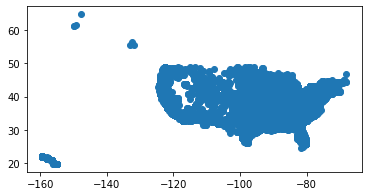

In [ ]:
final_gdf.plot()